In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = '/Users/alex/zriveAM/zrive-ds/aws/data/feature_frame.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id','created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [31]:
#quedarnos solo con ordenes de 5 o + productos
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """We are only interested in big enough orders that are profitable"""
    order_size=df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

df_selected = (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [32]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

In [33]:
daily_orders = df_selected.groupby("order_date").order_id.nunique()

In [34]:
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

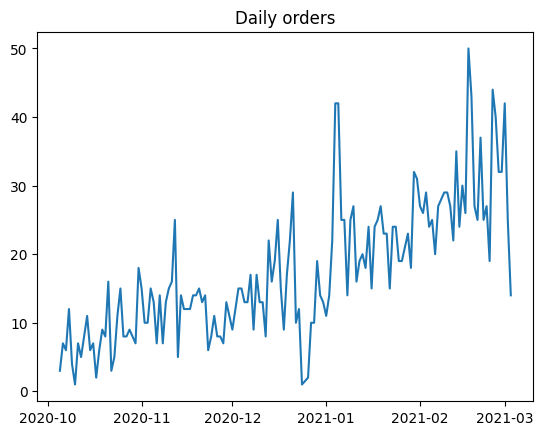

In [35]:
plt.plot(daily_orders)
plt.title("Daily orders")

Como hemos visto durante el EDA, hay una evolución fuerte que refleja el cambio del negocio, debido a ese cambio no podemos asumir que la base de usuarios ni las dinamicas de compras sean las mismas durante todo el tiempo. 


Asegurarnos de que ordenes no estan divididas entre train y validacion (toda la orden entera en train o validation), porque el modelo puede aprender por las features que dos productos son parecidos y ese usuario los compra los dos, si lo compra en train, lo va a comprar en test porque esta apareciendo la misma orden en los dos sitios.

Ademas de esto, temporal split, train va a ser mas antiguo y test mas nuevo 

In [37]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


Un potencial problema es que en una tendencia temporal hay que pensar en validar y testear con al menos un ciclo de negocio (un supermercado seria idoneo testear sobre una semana, no solo 2 dias, ya que puede ser que las compras de finde semana sean muy facil de predecir y el error sea menor del que realmente es), en este caso no hay problema porque tenemos suficientes datos

<Axes: xlabel='dayofweek'>

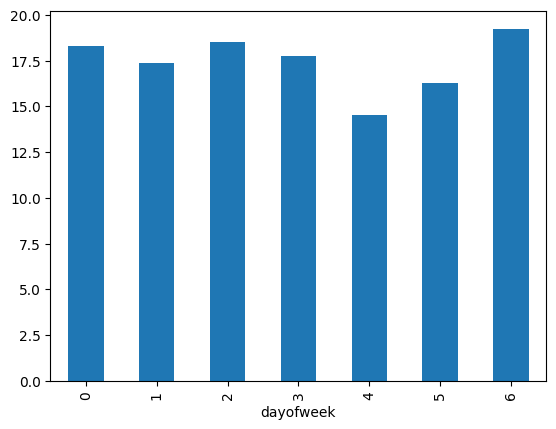

In [40]:
daily_orders.reset_index().assign(dayofweek=lambda x: pd.to_datetime(x.order_date).dt.dayofweek).groupby("dayofweek").order_id.mean().plot(kind="bar")

Vemos como el jueves comparado con el sabado es un 25% menor el tipo de ordenes, seguramente el tipo de productos que se venden en cada dia sean diferentes.

In [41]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date >= train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

## ***Baseline***

No podemos saber si algo es bueno o malo en el vacio. 

SIEMPRE SIEMPRE empezar con un baseline, un modelo es bueno o malo comparado con un baseline.

Hay muchos casos en los que el baseline esta muy cerca de la solución de ML, porque son dificiles de batir.


Ejemplo, random guess como baseline y que mi solucion mejoré random guess (en este caso si la proporcion es 97% de 0's y 3% de 1's, un 3% de las veces de forma aleatoria digo que es 1)


Baseline optimo ? --> ¿Si tengo que resolver el problema sin ML, que propongo? 

1. Sistema que ya existe antes de que pongamos nuestro modelo de ML

2. El mejor modelo posible que podamos hacer sin ML

Ejemplo: Sabemos que un 3% de la población tiene gripe, pero tenemos unas tablas por edad con probabilidad gripe (persona de 65 años 12% prob de gripe, persona de 8 años 4% de prob), es un buen baseline porque es mejor que random, y mi modelo de ML debe superar ese baseline.

Para justificar la complejidad añadida de tener un modelo de mL en produción hay que justificarlo con que supera el baseline (si existia un sistema antes ese es el baseline seguro).

 En este caso el baseline que se define es que la probabilidad de que un producto se compre, es su popularidad (mejor que random)

Se define tambien como se van a evaluar los modelos. Como hay un trade-off claro entre cuantas notificaciones mandamos a los usuarios y cuanto aumentamos las ventas (mayor nº de notificaciones aumentaria ventas pero tambien provocaria que usuarios se borren app --> ¿cuanto molesto a mis usuarios y cuanto consigo aumentar ls ventas? --> precision-recall --> vamos a fijarnos en la curva roc y curva precision-recall para cada modelo porque no se en que punto de trabajo va a querer trabajar el negocio)

In [48]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        target_precision: float = 0.05,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title("Precision-recall curve")
    ax[0].legend

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend()

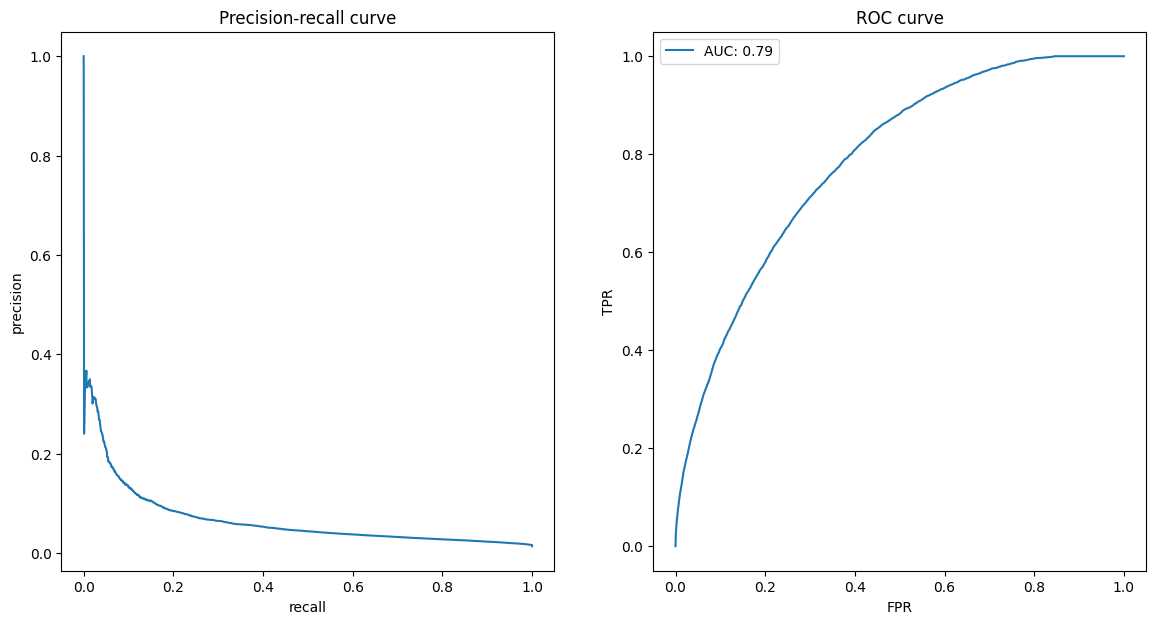

In [49]:
plot_metrics("Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col])

# Model training

Después de definir el baseline, se suele empezar por un modelo lineal, mi modelo lineal es mi segundo baseline, si con modelo no lineal no supero al modelo lineal no justifico la complejidad añadida.

1. Baseline (sin ML)

2. Modelo lineal ML basico

3. Modelos no lineales

In [50]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [ ]:
train_cols = numerical_cols + binary_cols

Columnas de entrenamiento seran numericas y binarias, dejo fuera categoricas porque para aumentar complejidad tengo que justificar que esa complejidad mejora los resultados.

Es un proceso de aumentar complejidad iterativamente, porque en cada paso si mayor complejidad no justifica resultados no deberia añadirlo

## Ridge regression

In [ ]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

